# Tutorial

This is a tutorial for MB-MVPA using task-fMRI data of Mixed-gamble task by Tom et al., 2007. 



### Import the MB-MVPA libarary.

Other libraries(nilean, keras, etc..) dosen't need to be imported.<br>
Because mb-mvpa has wrapping the libararies.<br>
You don't necessarily have to know fMRI libraries like nilearn and machine learning libraries like tensorflow.<br>
<b>MB-MVPA is all you need.</b>

Most of mb-mvpa are wrapping nilearn, tensorflow, Keras and etc., so warning can occur from that libraries.<br>
This page does not print warning because most of them are can be ignored.<br>
You don't need to remove the warning when you are actually using it.

In [1]:
from time import perf_counter

In [2]:
from mbmvpa.preprocessing.preprocess import DataPreprocessor

/home/cheoljun/.cache/pypoetry/virtualenvs/model-based-fmri-A7ELC43w-py3.7/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


TODO: add original data download link

Data download from AWS S3, ~ <b>1GB</b> (would be under the "Mixed-gamble_task/example_data/").<br>

We provide a small subset (2 subjects) of original Tom's dataset (16 subjects). The fMRI images in the example is preprocessed by conventional fMRI preprocessing pipeline by using 
[*fmriprep*](https://fmriprep.org/en/stable/) v.20.1.0. Please refer to the [original](https://openneuro.org/datasets/ds000005/versions/00001) for more information.

In [3]:
#root = load_example_data("tom")
root = "/data2/project_modelbasedMVPA/ds000005"

### Preprocessing fMRI images and behavioral data

MB-MVPA requires primariliy preprocessed task-fMRI experiments data fromatted in conventional [BIDS format](https://bids-specification.readthedocs.io/en/stable/) 

It expects the following organized files. All the naming conventions used here conform with outputs from *fmriprep* v.20.1.0. by Poldrack lab.

The fMRI images are usually located here<br>
<i>{BIDS_ROOT}/derivatives/fmriprep/subject/session/run/func/*nii.gz</i><br>
And the behavior data are located here<br>
<i>{BIDS_ROOT}/subject/session/run/func/*.tsv</i>

In [28]:
s = perf_counter()

dm_model = 'ra_prospect'

def example_adjust(row):
    ## rename data in a row to the name which can match hbayesdm.ra_prospect requirements ##
    row["gamble"] = 1 if row["respcat"] == 1 else 0
    row["cert"] = 0
    return row

def example_filter(row):
    # include all trial data
    return True

def example_latent(row, param_dict):
    ## calculate subjectives utility for choosing Gamble over Safe option
    ## prospect theory with loss aversion and risk aversion is adopted
    modulation = (row["gain"] ** param_dict["rho"]) - (param_dict["lambda"] * (row["loss"] ** param_dict["rho"]))
    row["modulation"] = modulation
    return row


preprocessor = DataPreprocessor(bids_layout=root,
                               adjust_function=example_adjust,
                               filter_function=example_filter,
                               latent_function=example_latent,
                               dm_model=dm_model,
                               zoom=(2,2,2))
print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

elapsed time: 0.58 minutes


In [29]:
preprocessor.summary()

[  fMRIPrep  ] BIDS Layout: .../ds000005/derivatives/fmriprep | Subjects: 16 | Sessions: 0 | Runs: 48
[  MB-MVPA   ] BIDS Layout: ...PA/ds000005/derivatives/mbmvpa | Subjects: 16 | Sessions: 0 | Runs: 48


In [30]:
s = perf_counter()

preprocessor.preprocess(overwrite=True,n_core=16)
#preprocessor.preprocess(overwrite=False,n_core=16)

print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

12it [05:14, 26.22s/it]


Using cached StanModel: cached-ra_prospect-pystan_2.19.1.1.pkl

Model  = ra_prospect
Data   = <pandas.DataFrame object>

Details:
 # of chains                    = 4
 # of cores used                = 4
 # of MCMC samples (per chain)  = 4000
 # of burn-in samples           = 1000
 # of subjects                  = 16
 # of (max) trials per subject  = 256

Using cached StanModel: cached-ra_prospect-pystan_2.19.1.1.pkl


/home/cheoljun/.cache/pypoetry/virtualenvs/model-based-fmri-A7ELC43w-py3.7/lib/python3.7/site-packages/hbayesdm/base.py:447: RuntimeWarning: Failed to get VB estimates for initial values. Use random values for initial values.
  RuntimeWarning, stacklevel=1)


Index(['onset', 'duration', 'parametric loss', 'distance from indifference',
       'parametric gain', 'gain', 'loss', 'ptval', 'respnum', 'respcat',
       'responsetime', 'subjid', 'run', 'gamble', 'cert'],
      dtype='object')
['onset', 'duration', 'parametric loss', 'distance from indifference', 'parametric gain', 'gain', 'loss', 'PTval', 'respnum', 'respcat', 'response_time', 'subjID', 'run', 'gamble', 'cert']
************************************
**** Model fitting is complete! ****
************************************
elapsed time: 33.49 minutes


In [8]:
preprocessor.summary()

[  fMRIPrep  ] BIDS Layout: .../ds000005/derivatives/fmriprep | Subjects: 16 | Sessions: 0 | Runs: 48
[  MB-MVPA   ] BIDS Layout: ...PA/ds000005/derivatives/mbmvpa | Subjects: 16 | Sessions: 0 | Runs: 48


### Load data and shape check

In [9]:
from mbmvpa.data.loader import BIDSDataLoader

In [10]:
s = perf_counter()

loader = BIDSDataLoader(layout=root)
X,y = loader.get_total_data()

print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

elapsed time: 0.18 minutes


In [11]:
print("X", X.shape)
print("y", y.shape)

X (11520, 571)
y (11520,)


In [12]:
voxel_mask = loader.get_voxel_mask()

### Fitting MVPA models & Results

In [13]:
from mbmvpa.models.mvpa_elasticnet import elasticnet

- lambda_best: 0.509, mse: 0.1199, survival rate (non-zero): 474/571


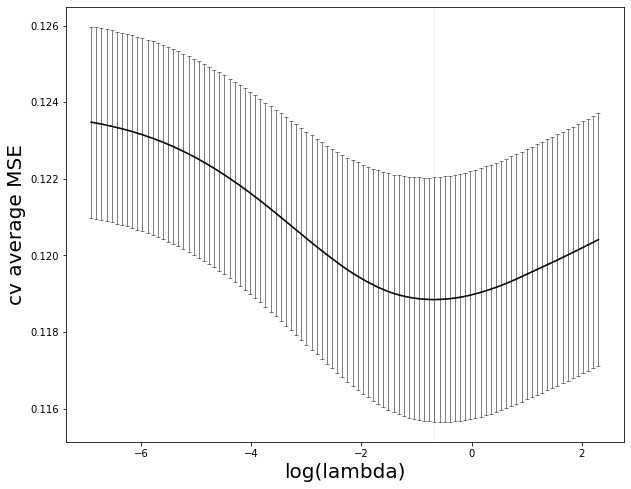

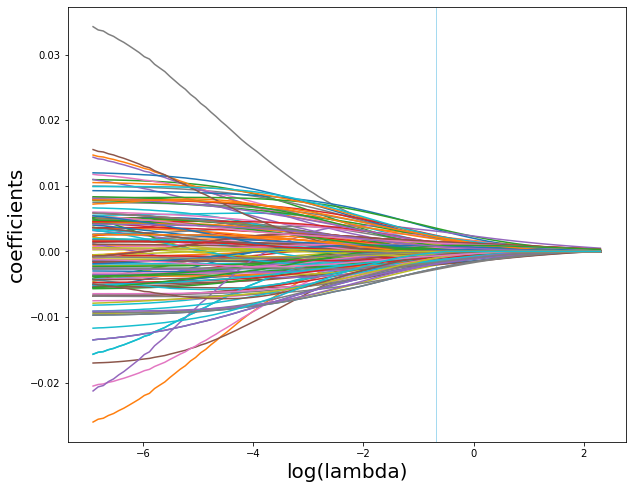

In [14]:
coef,intercept = elasticnet(X=X,
                  y=y,
                  voxel_mask=voxel_mask,
                  save_path='report_elasticnet',
                  sigma=0)

# survival coefs # report

In [15]:
coef.shape

(1, 571)

In [16]:
X.shape

(11520, 571)

In [17]:
coef.shape, intercept.shape

((1, 571), (1,))

In [18]:
import numpy as np
from scipy import stats

In [19]:
pred = np.matmul(coef,X.T) + intercept

In [20]:
stats.pearsonr(pred.flatten(),y.flatten())

(0.22081198631555043, 3.1961809219358534e-127)

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
import tqdm

In [23]:
r_test = []
r_train = []
for i in tqdm.tqdm(range(30)):
    ids = np.arange(X.shape[0])

    train_ids, test_ids = train_test_split(
                ids, test_size=0.2, random_state=42+i
            )



    coef,intercept = elasticnet(X=X[train_ids],
                      y=y[train_ids],
                      voxel_mask=voxel_mask,
                      save_path='report_elasticnet',
                      save=False,
                      verbose=0)

    r_train.append(stats.pearsonr((np.matmul(coef,X[train_ids].T) + intercept).flatten(),y[train_ids].flatten())[0])
    r_test.append(stats.pearsonr((np.matmul(coef,X[test_ids].T) + intercept).flatten(),y[test_ids].flatten())[0])

100%|██████████| 30/30 [02:50<00:00,  5.70s/it]


In [24]:
import matplotlib.pyplot as plt

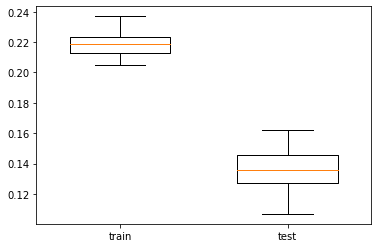

In [25]:
plt.boxplot([r_train, r_test], labels=['train','test'], widths=0.6)
plt.show()

In [26]:
print(r_train)

[0.2280889569472605, 0.23707325006379826, 0.20971991786436112, 0.2197085259613088, 0.20773485934026265, 0.23601763443349255, 0.21319350902874842, 0.21179679751922828, 0.21356160781646516, 0.21605480480694156, 0.20467867591243266, 0.2228324623831584, 0.2329393443377052, 0.2098685893387967, 0.21450033926410372, 0.21944144402057453, 0.2231293918179002, 0.22113735906859006, 0.21270853027721562, 0.22390824177954746, 0.22123856810938888, 0.22504757754211913, 0.21431655790457432, 0.21499933494178647, 0.21808170270953167, 0.22119280325514787, 0.22963002411577105, 0.2074886427517892, 0.20808683284003726, 0.2238503703804543]


In [27]:
print(r_test)

[0.14188134796610447, 0.12825062755851513, 0.14302580834079964, 0.15617201731825728, 0.14437555007416975, 0.11425928174333208, 0.13346555373632552, 0.15604713162534986, 0.11445029878079402, 0.13059687933755165, 0.12976841439563316, 0.1544219240192662, 0.10719859181255696, 0.12771330230456743, 0.14575363287911308, 0.1437566794397223, 0.12702543454479467, 0.10679053326268519, 0.14888688222095053, 0.14419232085996098, 0.11784029397511436, 0.13780297051098994, 0.1622832932444409, 0.14399050414701303, 0.12678546120897016, 0.12699551034776393, 0.12539518799234603, 0.1232813422453702, 0.15370288772775645, 0.15178020427297015]
